In [1]:
#Getting coordinates imports

from geopy.geocoders import Nominatim #Transform Adresses to Coordinates (EPSG:4326)
from osgeo.osr import SpatialReference, CoordinateTransformation #Changing coordinatesystem (EPSG:4326 to EPSG:31370)

#Opening and clipping tif imports

import rasterio #Handling tif files
import rioxarray #Handling Rasters

#Showing CHM

from rasterio.plot import show
import numpy as np

import matplotlib.pyplot as plt
import os
import numpy as np
from osgeo import gdal
import subprocess


In [2]:
#Using Geopy to enter a random adress and convert into EPSG:4326 coordinates

#Input Adress by user
adress = input("Please enter your adress (f.e.: Beliestraat 137 2910 Essen) here: ")

#Getting the coordinates in EPSG:4326 system (standard)
geolocator = Nominatim(user_agent = "coordinate_finder")
location = geolocator.geocode(adress)

Please enter your adress (f.e.: Beliestraat 137 2910 Essen) here: Beliestraat 137 2910 Essen


In [3]:
#Changing coordinatesystem from 4326 to EPSG:31370

#Importing EPSG:4326 system
epsg4326 = SpatialReference() 
epsg4326.ImportFromEPSG(4326)

#Importing EPSG:4326 system
epsg31370 = SpatialReference()
epsg31370.ImportFromEPSG(31370)

#Make a transform function to change coordinates from a EPSG:4326 to a EPSG:31370 system
transform = CoordinateTransformation(epsg4326, epsg31370)

#Run transform function on Address coordinates 
(adress_lat, adress_long, _) = transform.TransformPoint(location.latitude, location.longitude)

In [5]:
#Checking in which DSM/DTM tif file these coordinates are located

////////////////
NOG IN TE VULLEN
////////////////

156488.49577211653 239213.01287099905


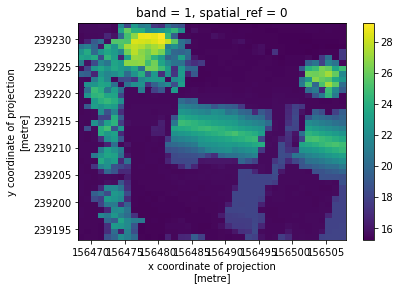

In [4]:
#Clipping of DSM tif

#Opening the DSM tif, read the mask and set values to NaN

DSM = rioxarray.open_rasterio("DHMVIIDSMRAS1m_k01.tif",
                                   masked=True)

#Choosing Boundary of the clip (in EPSG:31370 coordinates)
#on each side of the Adress coordinates

boundary = 20

#Left upper corner
xmin_ymax = [(adress_lat-boundary),(adress_long+boundary)]

#Right upper corner
xmax_ymax = [(adress_lat+boundary),(adress_long+boundary)]

#Left lower corner
xmax_ymin = [(adress_lat+boundary),(adress_long-boundary)]

#Right lower corner
xmin_ymin = [(adress_lat-boundary),(adress_long-boundary)]

#Making a polygon based on the boundaries around the Adress coordinates

clip_boundaries = [ {'type': 'Polygon',
                'coordinates': [[xmin_ymax,
                                 xmax_ymax,
                                 xmax_ymin,
                                 xmin_ymin ]]}]

#Actual clipping of the polygon from the DSM tif
   
clipped_DSM = DSM.rio.clip(clip_boundaries)

#Plotting the clipped DSM tif

clipped_DSM.plot()

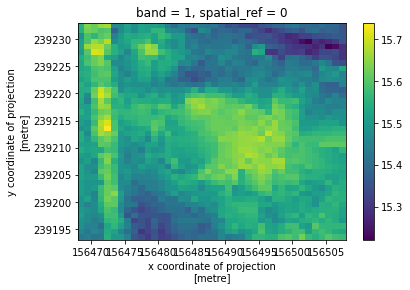

In [5]:
#Clipping of DTM tif

#Opening the DTM tif, read the mask and set values to NaN

DTM = rioxarray.open_rasterio("DHMVIIDTMRAS1m_k01.tif",
                                   masked=True)

#Choosing Boundary of the clip (in EPSG:31370 coordinates)
#on each side of the Adress coordinates

boundary = 20

#Left upper corner
xmin_ymax = [(adress_lat-boundary),(adress_long+boundary)]

#Right upper corner
xmax_ymax = [(adress_lat+boundary),(adress_long+boundary)]

#Left lower corner
xmax_ymin = [(adress_lat+boundary),(adress_long-boundary)]

#Right lower corner
xmin_ymin = [(adress_lat-boundary),(adress_long-boundary)]

#Making a polygon based on the boundaries around the Adress coordinates

clip_boundaries = [ {'type': 'Polygon',
                'coordinates': [[xmin_ymax,
                                 xmax_ymax,
                                 xmax_ymin,
                                 xmin_ymin ]]}]

#Actual clipping of the polygon from the DTM tif
   
clipped_DTM = DTM.rio.clip(clip_boundaries)

#Plotting the clipped DTM tif

clipped_DTM.plot()

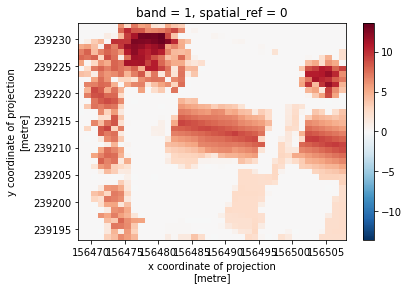

In [6]:
#Creating a Canopy Height Model of the clipped DSM and DTM

clipped_CHM = clipped_DSM - clipped_DTM 
clipped_CHM.compute()

clipped_CHM.plot()

In [7]:
print(clipped_CHM)

<xarray.DataArray (band: 1, y: 40, x: 40)>
array([[[0.05000019, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.01000023, 0.        , 0.02000046, ..., 0.        ,
         0.        , 0.        ],
        [0.01000023, 0.        , 0.03999996, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 2.41999912,
         2.43999958, 2.46000004],
        [0.        , 0.        , 0.        , ..., 2.42999935,
         2.4800005 , 2.4800005 ],
        [0.        , 0.        , 0.02999973, ..., 2.42000008,
         2.44000053, 2.45000076]]])
Coordinates:
  * y            (y) float64 2.392e+05 2.392e+05 ... 2.392e+05 2.392e+05
  * x            (x) float64 1.565e+05 1.565e+05 ... 1.565e+05 1.565e+05
  * band         (band) int32 1
    spatial_ref  int32 0


In [8]:
print(clipped_CHM[0,0,0])

<xarray.DataArray ()>
array(0.05000019)
Coordinates:
    y            float64 2.392e+05
    x            float64 1.565e+05
    band         int32 1
    spatial_ref  int32 0


In [9]:
values = clipped_CHM.values
print(values)

[[[0.05000019 0.         0.         ... 0.         0.         0.        ]
  [0.01000023 0.         0.02000046 ... 0.         0.         0.        ]
  [0.01000023 0.         0.03999996 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 2.41999912 2.43999958 2.46000004]
  [0.         0.         0.         ... 2.42999935 2.4800005  2.4800005 ]
  [0.         0.         0.02999973 ... 2.42000008 2.44000053 2.45000076]]]


In [10]:
clipped_CHM.shape

(1, 40, 40)

In [13]:
#Dataframe gemaakt met coordinates punten

import csv

for i in range(0,values.shape[0]):
    for j in range(0,values.shape[1]):
        for k in range(0,values.shape[2]):
            if i == 0 and j == 0 and k == 0:
                with open('chmdata.csv', 'w', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(['x', 'y', 'z'])
                    writer.writerow([i, j, values[i,j,k]])
            else:
                with open('chmdata.csv', 'a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow([i, j, values[i,j,k]])

In [11]:
import pandas as pd

chmchm = pd.read_csv("chmdata.csv")
display(chmchm)

chm = np.linspace((adress_lat-boundary),2* boundary)
                                                 (adress_lat+boundary)),
                                 y = np.linspace((adress_long-boundary)

#1600 rows  = 1 * 40 * 40

,x,y,z
0,0,0,0.050000
1,0,0,0.000000
2,0,0,0.000000
3,0,0,0.000000
4,0,0,0.000000
...,...,...,...
1595,0,39,0.000000
1596,0,39,2.430000
1597,0,39,2.420000
1598,0,39,2.440001


In [36]:
x_list = []
for i in range(0,40):
    x_list.append(i)
x_list *= (boundary*2)
print(x_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2

In [37]:
import plotly.graph_objects as go

import pandas as pd

# Read data from a csv
z_data = pd.read_csv('chmdata.csv')

fig = go.Figure(data=[go.Surface(x = x_list,
                                 y = z_data['y'].values,
                                 z=z_data['z'].values)])

fig.update_layout(title='3D plot house')

fig.show()

#Using mesh instead of surface

In [38]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Mesh3d(x = x_list,
                                 y = chmchm['y'].values,
                                 z= chmchm['z'].values,color='red', opacity=0.50)])
fig.show()

In [19]:
import plotly.express as px

fig = px.scatter_3d(x=np.linspace((adress_lat-boundary),
                                                 (adress_lat+boundary)),
                    y = np.linspace((adress_long-boundary),
                                                 (adress_long+boundary)),
                                 z=chmchm['z'].values)
fig.show()

ValueError: All arguments should have the same length. The length of argument `z` is 1600, whereas the length of  previously-processed arguments ['x', 'y'] is 50

In [ ]:
#extra for update 
    autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

ValueError: Argument Z must be 2-dimensional.

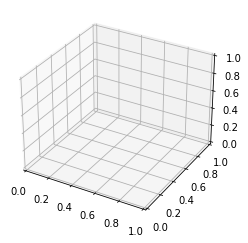

In [93]:

X = chmchm.iloc[:, 0]
Y = chmchm.iloc[:, 1]
Z = chmchm.iloc[:, 2]

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');

In [ ]:
#next steps:

1. get the shp files of the building:
    
https://docs.basisregisters.vlaanderen.be/docs/api-documentation.html#tag/Adressen
    
input adres 
--> get objectid for gebouweenheid 
--> get the object id for gebouw with it 
--> get the polygon with the gebouw id

2. 3D mathplotlib plot

In [ ]:
Website for the shapefiles of buildings in Belgium

http://download.geofabrik.de/europe.html